# Maintenance cost reduction


## Introduction


A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive maintenance solution to proactively identify when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

##GOAL
With building a predictive model using machine learning,we are going to predict the probability of a device failure.
When building this model, we should make sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.


In this kernel we will use various predictive models to see how accurate they are in detecting whether a machine is failed or not. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!



## Model Tuning
We consider predictive maintenance as a binary classification problem, because for a given prediction interval a device can be categorized as either functional or inoperative.
In general we aim at minimizing the error between predicted and actual
failures by selecting the model parameters according a predefined performance measures. Commonly used measures include the precision, the recall, and their harmonic mean, the F1-score. 
Informally speaking, the recall can be interpreted as the percentage of
actual failures that were correctly predicted, and the precision can be understood as the percentages of predicted failures that were actually true.
Their harmonic mean, the F1-score, is widely used in the machine learning
community to compare the performance of different models and parameter
settings.
Traditionally we aim at optimizing according to the F1-score, meaning
that we select all model parameters in a way that the harmonic mean of precision and recall is maximized on the training set. One important parameter
is the cutoff, which determines the threshold for binary classification and can
be visualized as different points on the ROC curve. Given the optimal parameters, including the cutoff, we are in the position to calculate potential
business savings of our trained model.

The success of predictive maintenance models depend on three main components: having the right data available, framing the problem appropriately and evaluating the predictions properly.
Let's start.
i used Google Colab for runnig my codes and optimizing my parameters, however as I first used AWS, I kept the uploading codes and just comment them out.

In [ ]:
# Imported Libraries

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.plotly as py 
import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.patches as mpatches




# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import collections
from sklearn.model_selection import cross_val_score

# Other Libraries
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time
from datetime import datetime

import warnings
import lightgbm as lgb
warnings.filterwarnings("ignore")



In [ ]:
# For Notebooks
init_notebook_mode(connected=True)

In [ ]:
# For offline use
cf.go_offline()

In [ ]:
#These line which are supposed to be in separate cells had been used for running this notebook on AWS.
# import boto3
#uclient = boto3.client('s3')
#path = 's3://jupyterasa/predictive_maintenance.csv'
#df = pd.read_csv(path)
#df= pd.read_csv("predictive_maintenance.csv")


In [ ]:
#If we run the notebook locally, we will use this cell.
#df= pd.read_csv("predictive_maintenance.csv")


In [ ]:
#for using google colab, we need to install this package and also runnig the following four cells.
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving predictive_maintenance.csv to predictive_maintenance.csv


In [1]:
#uploaded

In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "predictive_maintenance.csv" with length 6320082 bytes


In [ ]:
import io
df = pd.read_csv(io.StringIO(uploaded['predictive_maintenance.csv'].decode('utf-8')))
df.head()


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [ ]:
df.tail()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
124489,11/2/15,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,11/2/15,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,11/2/15,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,11/2/15,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124493,11/2/15,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [ ]:
df.shape

(124494, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


We've got a dataset with 124494 rows that is a collection of aggregated daily logs for devices with a failure indicator (the target) and unidentified attributes associated with each log entry. The date range of the data goes from January to November of 2015.



In [ ]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [ ]:
# found no nan value in the dataset 
df.isnull().sum() 

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

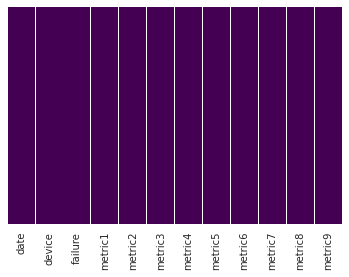

In [ ]:
#using seaborn to check if there is any missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

We can see that there is no missing data.

In [ ]:
#changing order of columns
df = df[['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9', 'date','device','failure' ]]

##EDA

The attributes are all integers, but many have the appearance of being error codes, with a large percentage of 0 values and large gaps between frequent occurances. This is common with devices that may have error codes that are bit encoded (eg. 2,4,8,16...1024, etc.). In a real world analysis, attempting to learn more about the meaning of the error codes that may be well documented, might help to develop categorical variables with more predictive power than treating the attributes as integer.

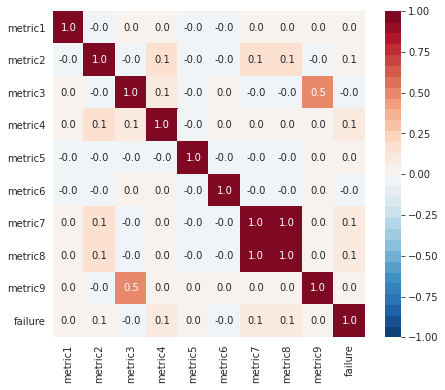

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.color_palette("RdBu_r", 30), annot=True, fmt='.1f');

6 attributes have very high percentage of zero values. These could be error codes or some other indicator many of the attributes are heavily skewed. These should be transformed for some analyses although this wasn't necessary for my models.
From correlation plot, we can see there is no signifcant correaltion between features and the response. The maximum correlation of between featuresd and the response is 0.1. Also, it shows that metric7 and metric8 are correlated with magnitude 1. Therefore, we can remove one of them.


In [ ]:
# removing metric7 column
df = df.drop(columns='metric7')

In [ ]:
# check for outlier, we use z-score to check if there are any outlier
z_score = df.loc[:,'metric1':'metric9'].copy()
z_score = z_score.sub(z_score.mean(), axis=1).div(z_score.std(), axis=1)
outliers = (abs(z_score) > 3).sum().sort_values()
outliers

metric1       0
metric6      80
metric8     253
metric3     435
metric2     456
metric9     515
metric4     728
metric5    4749
dtype: int64

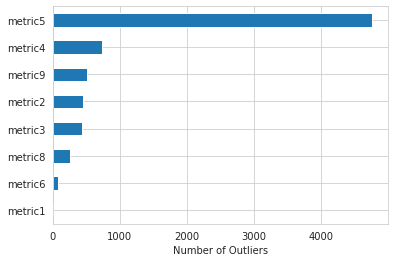

In [ ]:
outliers.plot(kind='barh');
plt.xlabel('Number of Outliers');

Metric 5 has the most number of outliers and metric 1 has the least.

In [ ]:
# convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# From date column, we create new date-related features: 'Day of Week', 'Day' and 'Month'.
df['Day of Week'] = df['date'].apply(lambda time: time.dayofweek)
df['Day'] = df['date'].apply(lambda time: time.day).astype(int)
df['Month'] = df['Month'] = df['date'].apply(lambda time: time.month)

In [ ]:
#Day of Week is an integer 0-6. I made a dictionary to map the actual string names to the day of the week:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [ ]:
#Converting numerical week days to alphabetical format. 
df['Day of Week'] = df['Day of Week'].map(dmap)

In [ ]:
df.head()

,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,date,device,failure,Day of Week,Day,Month
0,215630672,56,0,52,6,407438,0,7,2015-01-01,S1F01085,0,Thu,1,1
1,61370680,0,3,0,6,403174,0,0,2015-01-01,S1F0166B,0,Thu,1,1
2,173295968,0,0,0,12,237394,0,0,2015-01-01,S1F01E6Y,0,Thu,1,1
3,79694024,0,0,0,6,410186,0,0,2015-01-01,S1F01JE0,0,Thu,1,1
4,135970480,0,0,0,15,313173,0,3,2015-01-01,S1F01R2B,0,Thu,1,1


In [ ]:
#checking number of failure per month
byMonth= df[(df['failure'] == 1)].groupby('Month').count()
byMonth['device']

Month
1     24
2     14
3      9
4      9
5     21
6      6
7     16
8      4
10     3
Name: device, dtype: int64

In [ ]:
df.groupby('Month')['failure'].agg(['size', 'mean'])

,size,mean
Month,,
1,25032,0.000959
2,19500,0.000718
3,19833,0.000454
4,12012,0.000749
5,11330,0.001853
6,10469,0.000573
7,10531,0.001519
8,8346,0.000479
9,4470,0.000000


The most failures have been happend in January. However, as we just have data of one year, we really don't know about next cycle (we don't have enough data).

In [ ]:
#counting how many devices are failed in each day of week, separating them monthly.
ByFail=df[df['failure']==1]
ByFail.groupby(by=['Day of Week', 'Month']).count()['device'].unstack().fillna(0).astype(int)

Month,1,2,3,4,5,6,7,8,10
Day of Week,,,,,,,,,
Fri,3,1,0,2,3,1,1,0,1
Mon,10,5,0,3,2,0,3,2,2
Sat,1,2,0,0,2,0,3,0,0
Sun,1,0,0,0,0,1,2,0,0
Thu,3,2,3,2,6,2,4,0,0
Tue,3,0,4,2,4,1,2,2,0
Wed,3,4,2,0,4,1,1,0,0


First Monday of January, we have 10 failed devices! As we have 106 failure in the whole 2015 year, 10 failure is 9% of all failures.

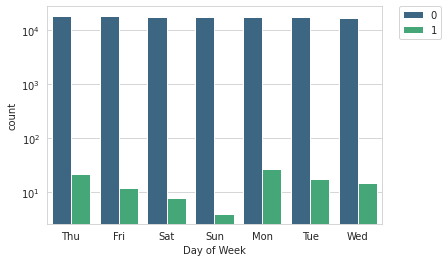

In [ ]:
#Now I use seaborn library to create a countplot of the Day of Week column and failure
sns.countplot(x='Day of Week',data=df,hue='failure',palette='viridis')

# To relocate the legend:
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

We can see more failures on Mondays and Tuesdays and the least failure on Sundays. Probabley because the most usage has been occured on Mondays.

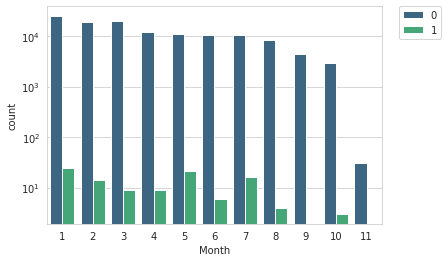

In [ ]:
#We do the same to check failure in different months and numbers are months respectely (January =1 , February =2 and so on)
sns.countplot(x='Month',data=df,hue='failure',palette='viridis')

# To relocate the legend:
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')

As we go further toward the end of the year, number of monthly failures  decreases.

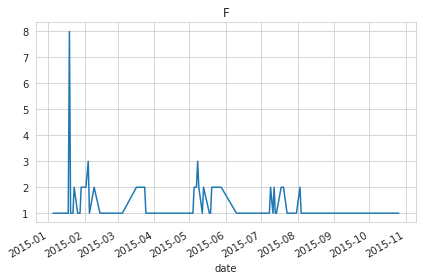

In [ ]:
#Checking time series of failure.
df[df['failure']==1].groupby('date').count()['device'].plot()
plt.title('F')
plt.tight_layout()

As we get closer to the end of the year, we can see less and less failure.

In [ ]:
df['device'].nunique()

1169

We have 1169 different types of devices. Which means we  have an average of 106 reports for each device.

In [ ]:
df.groupby('failure')['device'].nunique()

failure
0    1169
1     106
Name: device, dtype: int64

In our 1169 different types of devices and 124494 recording reports, only 106 devices show some sort of failure.


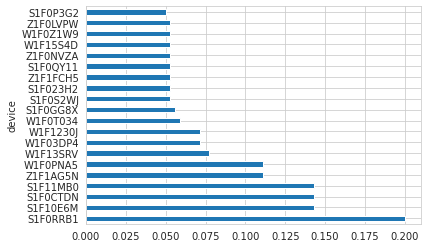

In [ ]:
# percetange of failure for each device
t = df.groupby(by = 'device')['failure'].mean()
t.sort_values(ascending=False).head(20).plot(kind='barh')

Some devices has higher precentage of reported failure. Device S1F10RRB1 has the highest number of failure. Our metrics are not labeled, so we don't know about the age of this device and their utilization. We expect to notice a very strong and consistent correlation between high utilization and higher failure rates. Another possible explanation is that previous observations of high correlation between utilization and failures has been based on extrapolations from manufacturers’ accelerated life experiments. Temperature is also quoted as the most important environmental factor affecting disk drive reliability. 

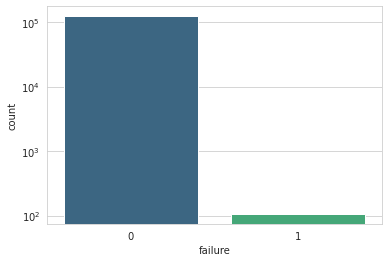

In [ ]:
sns.countplot(x='failure',data=df,palette='viridis')
plt.yscale('log')

Notice how imbalanced is our original dataset!We only have 0.06 failure .

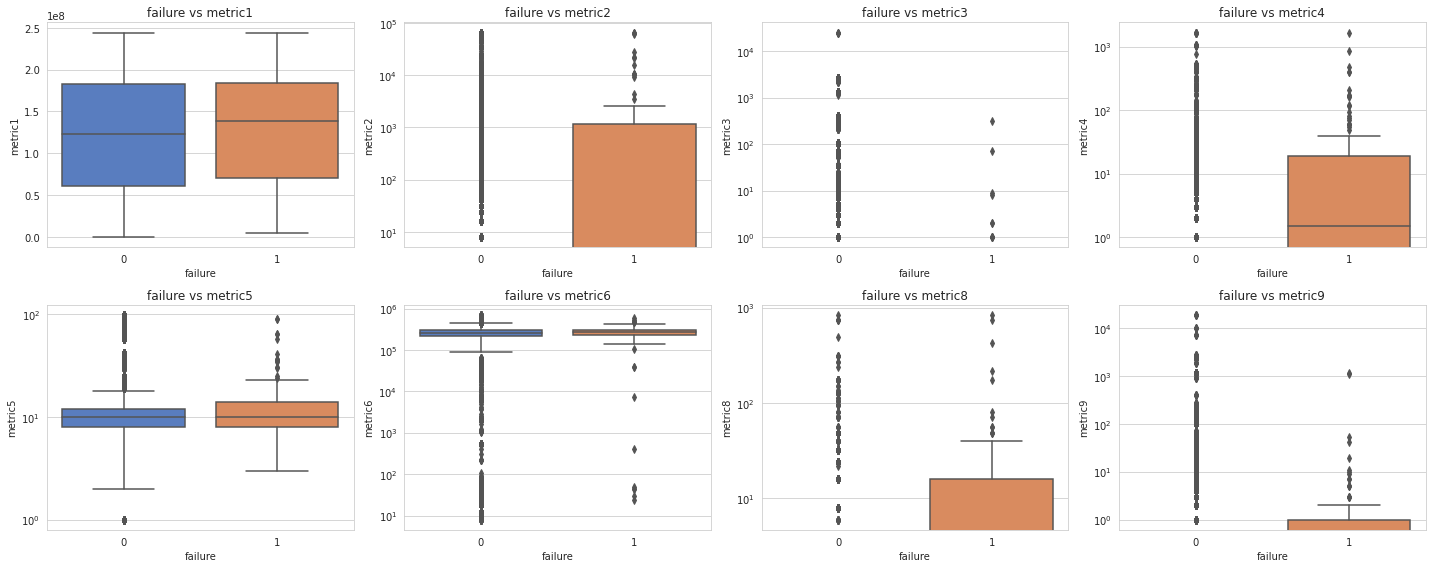

In [ ]:
plt.figure(figsize=(20,8))

# checking box plot of our metrics with failure
plt.subplot(2,4, 1)
sns.boxplot(x="failure", y="metric1", data=df, palette="muted")
plt.title('failure vs metric1')

plt.subplot(2,4, 2)
sns.boxplot(x="failure", y="metric2", data=df, palette="muted")
plt.title('failure vs metric2')
plt.yscale('log')

plt.subplot(2,4, 3)
sns.boxplot(x="failure", y="metric3", data=df, palette="muted")
plt.title('failure vs metric3')
plt.yscale('log')

plt.subplot(2,4, 4)
sns.boxplot(x="failure", y="metric4", data=df, palette="muted")
plt.title('failure vs metric4')
plt.yscale('log')

plt.subplot(2,4, 5)
sns.boxplot(x="failure", y="metric5", data=df, palette="muted")
plt.title('failure vs metric5')
plt.yscale('log')

plt.subplot(2,4, 6)
sns.boxplot(x="failure", y="metric6", data=df, palette="muted")
plt.title('failure vs metric6')
plt.yscale('log')

plt.subplot(2,4, 7)
sns.boxplot(x="failure", y="metric8", data=df, palette="muted")
plt.title('failure vs metric8')
plt.yscale('log')

plt.subplot(2,4, 8)
sns.boxplot(x="failure", y="metric9", data=df, palette="muted")
plt.title('failure vs metric9')
plt.yscale('log')

plt.tight_layout()

Boxplot shows that the metrics do not provide much seperation between two classes. Also, the distibution of metrics is not well-behaved.

## Feature Engineering

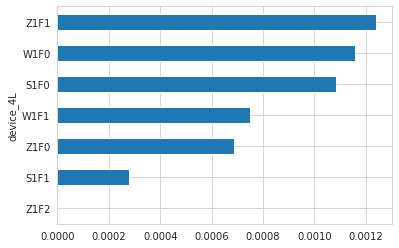

In [ ]:
# instead of using device as a feature, we use only the first 4 letters(of devices) to reduce the number of dummies we need to modeling
# percentage of failure based on the first 4 letters of device
df['device_4L'] = df['device'].str[:4]
df.groupby('device_4L')['failure'].mean().sort_values().plot(kind='barh');

This figure shows that Z1F1 device, has the highest number of failures, recorded.


In [ ]:
# process of making dummy variables for two categorical and timestamp columns.
df_dummy = pd.get_dummies(df, columns=['Day of Week', 'device_4L'],drop_first = True)
df_dummy = df_dummy.drop(columns=['date', 'device'])

## Standardize The Variables

**Scaling and Distributing**
In this phase of our kernel, we will first scale the Metric columns that are skewed. We need to scale and standardize our dataset.

In [ ]:
scaler = StandardScaler()
df_scaled = df_dummy.copy()
df_scaled[:] = scaler.fit_transform(df_dummy)
df_scaled['failure'] = df_dummy['failure'].copy()


## **Classifiers:**
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting failured devices.We will use: Logistic Regression, KNN, Decision Tree and Random Forest and later on Gradient Boosting.
<br>

**RandomSearchCV** is used to determine the paremeters that gives the best predictive score for the classifiers.
<br>

**Learning Curves:**  The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias) bold text
ws the best score in both training and cross-validating sets.

In [ ]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [ ]:
#Stratified K-Folds cross-validator that provides train/test indices to split data in train/test sets
#This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
# Caculating accuracy of each classifier
from sklearn.model_selection import cross_val_score

X = df_scaled.drop(columns='failure')
y = df_scaled['failure']

for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X, y, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 4) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 99.89 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 99.91 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 82.55 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 99.78 % accuracy score


Since the response is highly imbalanced, accuracy is not a good metric to evaluate different models. **AUC** is the primary evaluation metric since I don't have any information to weight the cost of false positives (unnecessary inspection) and false negatives (failure in the field). Since those probably aren't equivalent, its prudent to plot other evaluation metrics as a function of the cutoff.

In [ ]:
 # Use RandomizedSearchCV to find the best parameters.
from sklearn.model_selection import RandomizedSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, scoring='roc_auc')
rand_log_reg.fit(X, y)
# We automatically get the logistic regression with the best parameters.
log_reg = rand_log_reg.best_estimator_
print(rand_log_reg.best_params_)

# Knearest Neighbor Classifier
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
rand_knears = RandomizedSearchCV(KNeighborsClassifier(), knears_params, scoring='roc_auc')
rand_knears.fit(X, y)
# KNears best estimator
knears_neighbors = rand_knears.best_estimator_
print(rand_knears.best_params_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
rand_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, scoring='roc_auc')
rand_tree.fit(X, y)

# Decision Tree best estimator
tree_clf = rand_tree.best_estimator_
print(rand_tree.best_params_)

# RandomForest Classifier
rf_params = {"criterion": ["gini", "entropy"], "max_depth": [4,8,12], 
              "max_features": [5, 10, 15]}
rand_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, scoring='roc_auc')
rand_rf.fit(X, y)
# Random Forest best estimator
rf_clf = rand_rf.best_estimator_
print(rand_rf.best_params_)

{'penalty': 'l2', 'C': 0.001}
{'n_neighbors': 4, 'algorithm': 'ball_tree'}
{'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'entropy'}
{'max_features': 15, 'max_depth': 4, 'criterion': 'gini'}


In [ ]:
log_reg_pred = cross_val_predict(log_reg, X, y, cv=3, method='predict_proba')
knears_pred = cross_val_predict(knears_neighbors, X, y, cv=3, method='predict_proba')
tree_pred = cross_val_predict(tree_clf, X, y, cv=3, method='predict_proba')
rf_pred = cross_val_predict(rf_clf, X, y, cv=3, method='predict_proba')

In [ ]:
print('Logistic Regression: ', roc_auc_score(y, log_reg_pred[:,1]))
print('KNears Neighbors: ', roc_auc_score(y, knears_pred[:,1]))
print('Decision Tree Classifier: ', roc_auc_score(y, tree_pred[:,1]))
print('Random Forest Classifier: ', roc_auc_score(y, rf_pred[:,1]))

Logistic Regression:  0.7884019025071277
KNears Neighbors:  0.5459540476209256
Decision Tree Classifier:  0.8167657151299554
Random Forest Classifier:  0.8638574839774024


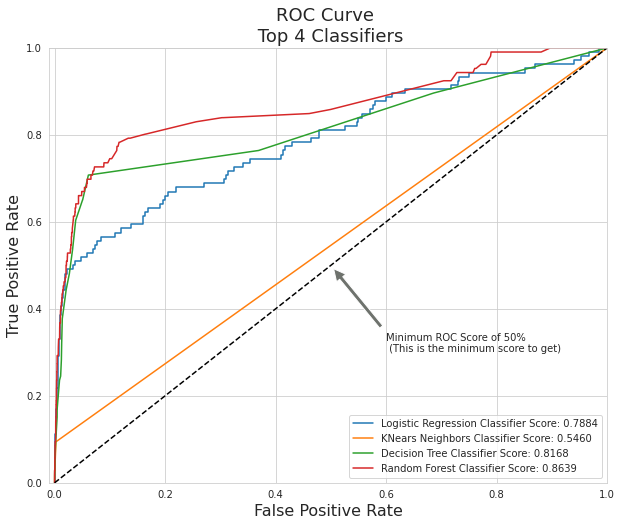

In [ ]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y, log_reg_pred[:,1])
knear_fpr, knear_tpr, knear_threshold = roc_curve(y, knears_pred[:,1])
tree_fpr, tree_tpr, tree_threshold = roc_curve(y, tree_pred[:,1])
rf_fpr, rf_tpr, rf_threshold = roc_curve(y, rf_pred[:,1])


plt.figure(figsize=(10,8))
plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y, log_reg_pred[:,1])))
plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y, knears_pred[:,1])))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y, tree_pred[:,1])))
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y, rf_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
              arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
    
plt.show()

We can see that Random Forest Classifier shows a better ROC score.

## Checking Random Forest Classifier
Random forests are among the most popular machine learning methods thanks to their relatively good accuracy, robustness and ease of use. They also provide straightforward methods for feature selection. One of them is feature_importances method.
Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

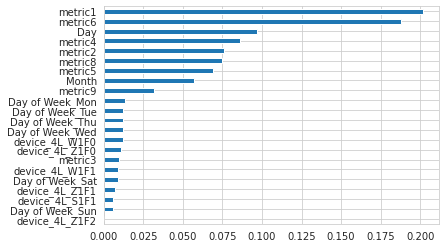

In [ ]:
rf = RandomForestClassifier()
rf.fit(X,y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')

Above figure shows the feature importance from Random Forest. It shows that metric1 and metric6 has the highest importance to separating response. Features generated from date is not as important as metrics.

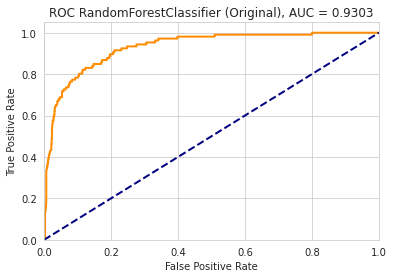

In [ ]:
# We apply Random Forest Classifier on original data (without any oversampling or under sampling and check the AUC result)
X_np = X.values
y_np = y.values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_prob = np.zeros(y_np.shape)
for train, test in kf.split(X_np, y_np):
  rf = RandomForestClassifier(max_depth=12, max_features = 6, random_state=123)  
  rf.fit(X_np[train], y_np[train])
  y_prob[test] = rf.predict_proba(X_np[test])[:,1]

fpr, tpr, thresholds = roc_curve(y_np, y_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier (Original), AUC = {0:.4f}'.format(roc_auc_score(y_np, y_prob)))
plt.show()

### Random Undersampling:


In this phase of the project we will implement "Random Under Sampling" ,using NearMiss, which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

**Near Miss Undersampling:**

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.


 **Note:**
The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (**bringing 106 failed devices from 124,494 non-failed devices**).

No handles with labels found to put in legend.


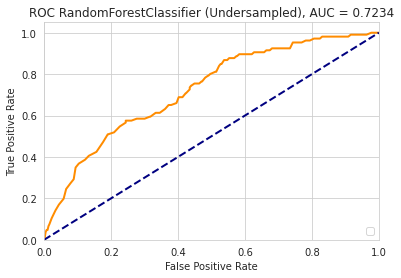

In [ ]:
# NearMiss Undersampling

# X_np = X.values
# y_np = y.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
undersample_prediction = np.zeros(y_np.shape)
undersample_prob = np.zeros(y_np.shape)

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train, test in sss.split(X_np, y_np):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), RandomForestClassifier(max_depth=14, random_state=123)) # NearMiss happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(X_np[train], y_np[train])
    undersample_prediction[test] = undersample_model.predict(X_np[test])
    undersample_prob[test] = undersample_model.predict_proba(X_np[test])[:,1]

    undersample_accuracy.append(undersample_pipeline.score(X_np[test], y_np[test]))
    undersample_precision.append(precision_score(y_np[test], undersample_prediction[test]))
    undersample_recall.append(recall_score(y_np[test], undersample_prediction[test]))
    undersample_f1.append(f1_score(y_np[test], undersample_prediction[test]))
    undersample_auc.append(roc_auc_score(y_np[test], undersample_prob[test]))
np.mean(undersample_f1) 

fpr, tpr, thresholds = roc_curve(y_np, undersample_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier (Undersampled), AUC = {0:.4f}'.format(roc_auc_score(y_np, undersample_prob)))
plt.legend(loc="lower right")
plt.show()

We did't get a good result, comparing to applying Random forest on the original data, we can say that undersampling doesn't help.



**SMOTE Technique (Over-Sampling):**


<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>



No handles with labels found to put in legend.


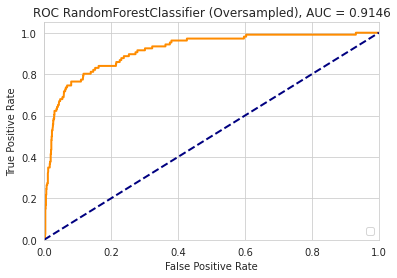

In [ ]:
# We apply Random Forest and using SMOTE oversampling technique

oversample_accuracy = []
oversample_precision = []
oversample_recall = []
oversample_f1 = []
oversample_auc = []
oversample_prediction = np.zeros(y_np.shape)
oversample_prob = np.zeros(y_np.shape)
for train, test in sss.split(X_np, y_np):
    oversample_pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), RandomForestClassifier(max_depth=12, max_features=6, random_state=123)) # SMOTE happens during Cross Validation not before..
    oversample_model = oversample_pipeline.fit(X_np[train], y_np[train])
    oversample_prediction[test] = oversample_model.predict(X_np[test])
    oversample_prob[test] = oversample_model.predict_proba(X_np[test])[:,1]

    oversample_accuracy.append(oversample_pipeline.score(X_np[test], y_np[test]))
    oversample_precision.append(precision_score(y_np[test], oversample_prediction[test]))
    oversample_recall.append(recall_score(y_np[test], oversample_prediction[test]))
    oversample_f1.append(f1_score(y_np[test], oversample_prediction[test]))
    oversample_auc.append(roc_auc_score(y_np[test], oversample_prob[test]))
np.mean(oversample_f1) 

fpr, tpr, thresholds = roc_curve(y_np, oversample_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForestClassifier (Oversampled), AUC = {0:.4f}'.format(roc_auc_score(y_np, oversample_prob)))
plt.legend(loc="lower right")
plt.show()

Comparing the AUC of applying Random forest on original data, undersampled data and oversampled data, **Applying Random Forest on Original data** shows the best AUC.

No handles with labels found to put in legend.


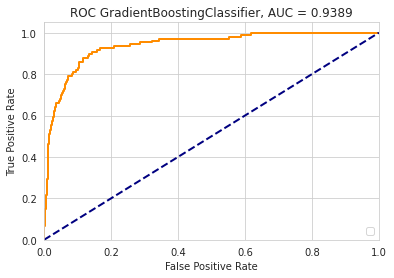

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_prob = np.zeros(y_np.shape)
for train, test in kf.split(X_np, y_np):
  gb = GradientBoostingClassifier(max_depth=12, max_features = 8 , random_state=145)
  gb.fit(X_np[train], y_np[train])
  y_prob[test] = gb.predict_proba(X_np[test])[:,1]

fpr, tpr, thresholds = roc_curve(y_np, y_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GradientBoostingClassifier, AUC = {0:.4f}'.format(roc_auc_score(y_np, y_prob)))
plt.legend(loc="lower right")
plt.show()

We got the best ROC_auc_score, from applying GradientBoost on the original data. Gradient boosting can result in better performance than random forests. However, gradient boosting may not be a good choice if you have a lot of noise, as it can result in overfitting. They also tend to be harder to tune than random forests. So, I keep continunig with Random forst.

## A Deeper Look into RandomForest:
<a id="logistic"></a>
In this section we will dive a deeper look into the <b> Random Forest classifier</b>.

The random forest model is advantageous, since it has only a few parameters and, therefore, requires comparatively little training data. Furthermore
it can handle unbalanced data sets, allows for feature ranking, and is
relatively easy to interpret. Most importantly, the individual decision trees
can model temporal dependencies, since their decision paths (root node to
leaf node) assign an order to the features that were extracted from consecutive time periods .



**Confusion Matrix:**

**Positive/Negative:** Type of Class (label) ["No", "Yes"]
**True/False:** Correctly or Incorrectly classified by the model.<br><br>

**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No failure Detected) class. <br><br>

**False Negatives (Top-Right Square):** This is the number of **incorrectly** classifications of the "No"(No failure Detected) class. <br><br>

**False Positives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (failure Detected) class <br><br>

**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (failure Detected) class.



Text(0.5, 1.0, 'RandomForest Classifier \n Confusion Matrix')

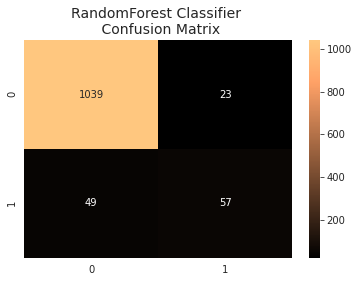

In [ ]:
#Confusion matrix
rf_cf = confusion_matrix(y, y_pred_rf)
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper, fmt='d')
plt.title("RandomForest Classifier \n Confusion Matrix", fontsize=14)

In [ ]:
best_thr = np.argmax(f1_list)
y_pred_rf = 1*(y_prob>thrs[best_thr])
print('Random Forest Classifier:')
print(classification_report(y, y_pred_rf))


Random Forest Classifier:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      1062
         1.0       0.71      0.54      0.61       106

    accuracy                           0.94      1168
   macro avg       0.83      0.76      0.79      1168
weighted avg       0.93      0.94      0.93      1168



In [ ]:
best_thr_over = np.argmax(f1_list)
y_pred_oversample_rf = 1*(oversample_prob>thrs[best_thr_over])
print('Random Forest Classifier:')
print(classification_report(y, y_pred_oversample_rf))

I aggregated over each device (we had 1168 devices) and then calculated the confusion matrix. 
 For predicting failure which is what we want (The ture positive), This model (Random Forest on Original data) catches about half the cases(54%) using a cutoff of 0.3.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
y_prob = np.zeros(y_np.shape)
for train, test in kf.split(X_np, y_np):
  rf = RandomForestClassifier(max_depth=12, random_state=123, max_features=6) 
  rf.fit(X_np[train], y_np[train])
  y_prob[test] = rf.predict_proba(X_np[test])[:,1]

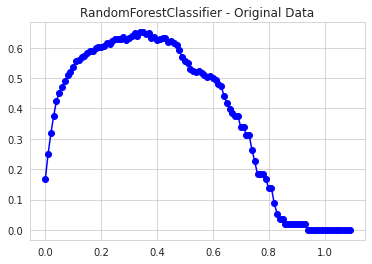

In [ ]:
f1_list = []
thrs = np.arange(0,1.1,.01)
for thr in thrs:
  f1_list.append(f1_score(y_np, 1*(y_prob>thr)))
plt.plot(thrs, f1_list, 'b-o')
plt.title('RandomForestClassifier - Original Data');

In [ ]:
confusion_matrix(y_np, y_pred_rf)

array([[1039,   23],
       [  49,   57]])

Our model predicts 57 cases from total 106 cases(a little bit more than half of the cases). 

##More exploration based on Date and Device features
 At this point, I want to focus on time and device and explore more information about that.

In [ ]:
#read our data again
df = pd.read_csv(io.StringIO(uploaded['predictive_maintenance.csv'].decode('utf-8'))).drop(columns='metric8')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['device', 'date'])

Text(0, 0.5, 'number of records')

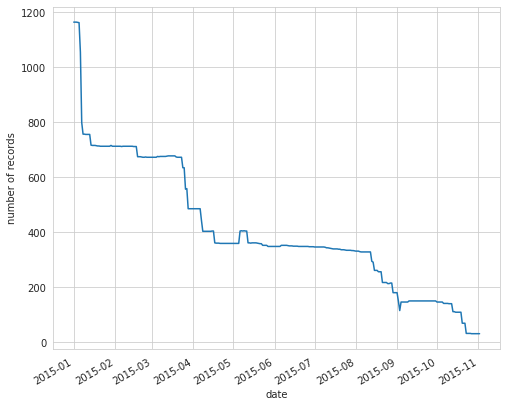

In [ ]:
#Having a time series plot to check recording trend 
plt.figure(figsize=(8,7))
df.groupby('date').size().plot()
#sns.rugplot(df['date'])
plt.xlabel('date')
plt.ylabel('number of records')


As we can see, number of records decreasing over time, representing a shrinking of the device population as time proceeds.

###EDA Device Time Series


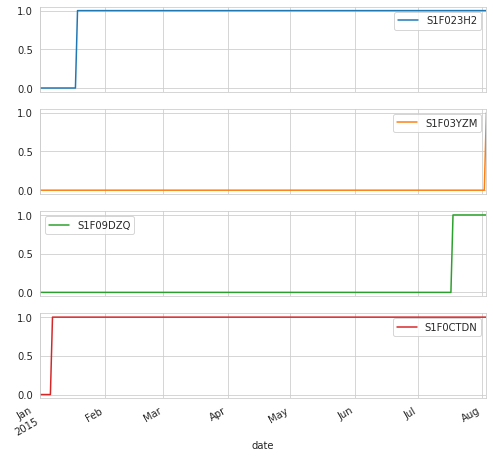

In [ ]:
#We chose the 4 types of devices withe most failure
withfailure = df.groupby('device').filter(lambda x: x['failure'].sum() > 0)
selected = withfailure['device'].unique()[:4]

withfailure[withfailure['device'].isin(selected)].pivot(index='date', columns='device', values='failure').fillna(1).plot(subplots=True, layout=(4,1), figsize=(8,8));

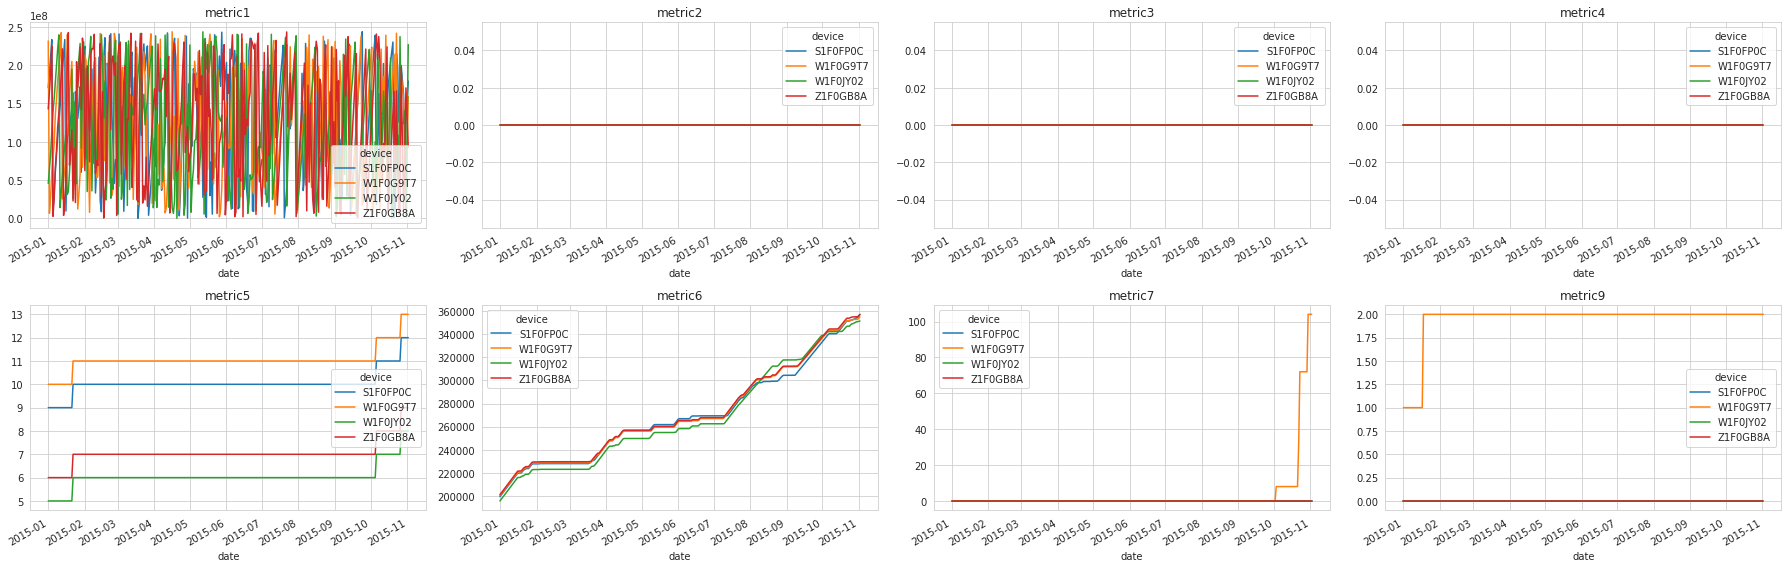

In [ ]:
bydevice = df.groupby('device')['failure'].agg(['mean', 'size']).sort_values('size', ascending=False)
passed = bydevice[bydevice['mean'] == 0].index[:4]

metrics = df.columns[df.columns.str.contains('met')]
plt.figure(figsize=(25, 8))
for i, met in enumerate(metrics):
  ax = plt.subplot(2,4,i+1)
  df[df['device'].isin(passed)].pivot(index='date', columns='device', values=met).plot(ax=ax);
  plt.title(met)
plt.tight_layout()



*   There no records for metric2, metric3 and metric4 for 3 out of 4 top most failed devices.
*   Top 4 most failed devices show similar behavior in metric5 and metric6.
*   There in no data in metric 7 for device S1F0FP0C and S1F0FP0C and for device Z1F0GBBA, all records are zeros and there is no data for device W1F0G9T7.
*   There in no data in metric 9 for device S1F0FP0C and S1F0FP0C and for device Z1F0GBBA, all records are zeros.







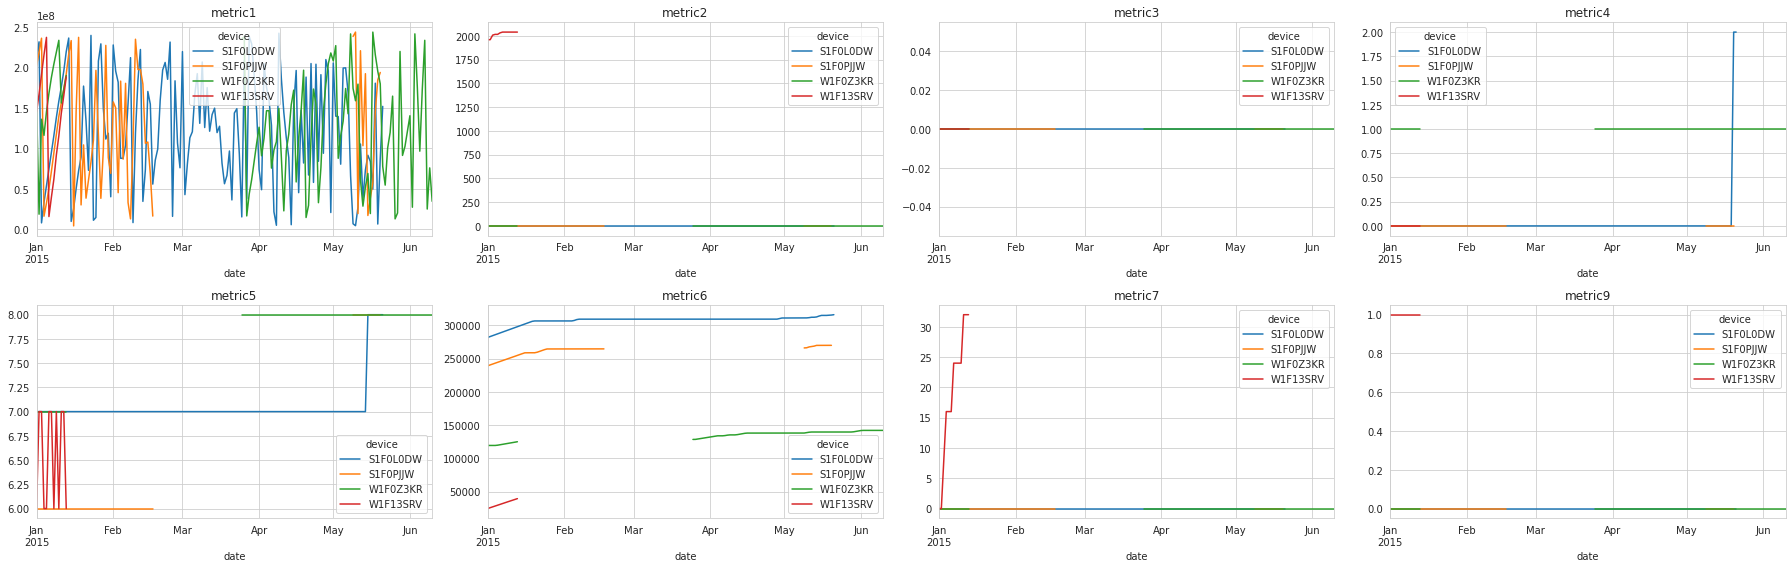

In [ ]:
failed = bydevice[bydevice['mean'] != 0].sample(4, random_state=123).index
plt.figure(figsize=(25, 8))
for i, met in enumerate(metrics):
  ax = plt.subplot(2,4,i+1)
  df[df['device'].isin(failed)].pivot(index='date', columns='device', values=met).plot(ax=ax);
  plt.title(met)
plt.tight_layout()

Most the devices are removed from the log at some point or not all their metrics have been recorded, but the ratio of failures in the log file are extrmely small (0.09%), because devices report success until they fail.

In [ ]:
#defining more attributes for evaluation 
cols = [f'{x}_mean' for x in metrics] + [f'{x}_std' for x in metrics] + [f'{x}_diff' for x in metrics] + [f'{x}_min' for x in metrics] + [f'{x}_max' for x in metrics] + [f'{x}_slope' for x in metrics] 
def device_aggregation(rows):
  f1 = rows[metrics].mean()
  f2 = rows[metrics].std()
  f3 = rows[metrics].diff().mean()
  f4 = rows[metrics].min()
  f5 = rows[metrics].max()
  f6 = rows[metrics].iloc[0,:] - rows[metrics].iloc[-1,:] 
  res = pd.concat((f1,f2,f3,f4,f5,f6))
  res.index = cols
  res['failure'] = rows['failure'].any()
  return res

In [ ]:
#making a new dataframe
newdf = df.groupby('device').apply(device_aggregation).dropna()

In [ ]:
X = newdf.drop(columns='failure')
y = newdf['failure']

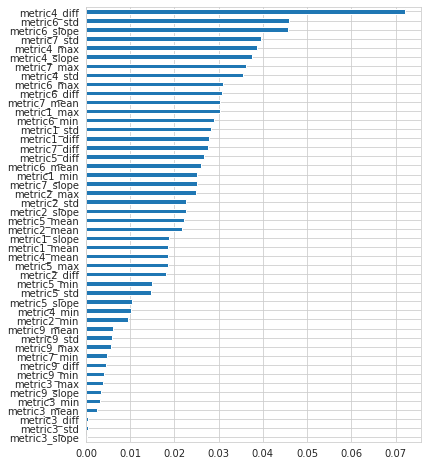

In [ ]:
rf = RandomForestClassifier()
rf.fit(X,y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(6,8));

In [ ]:
rf_pred[:,1]

array([0.00661494, 0.00040243, 0.00039621, ..., 0.00201596, 0.00036833,
       0.00036381])

No handles with labels found to put in legend.


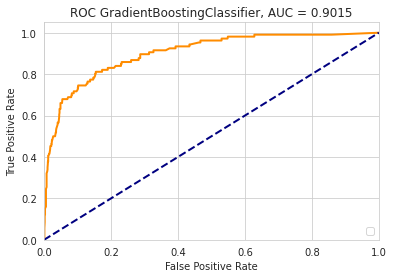

In [ ]:
rf_pred = cross_val_predict(RandomForestClassifier(max_depth=16, max_features=5, random_state=241), X, y, cv=5, method='predict_proba')

fpr, tpr, thresholds = roc_curve(y, rf_pred[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',  lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC GradientBoostingClassifier, AUC = {0:.4f}'.format(roc_auc_score(y,  rf_pred[:,1])))
plt.legend(loc="lower right")
plt.show()

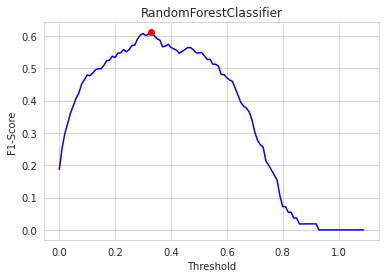

In [ ]:
f1_list = []
thrs = np.arange(0,1.1,.01)
for thr in thrs:
  f1_list.append(f1_score(y, 1*(rf_pred[:,1]>thr)))
plt.plot(thrs, f1_list, 'b-')

best_thr = np.argmax(f1_list)
plt.plot(thrs[best_thr], f1_list[best_thr], 'ro')
plt.title('RandomForestClassifier');
plt.xlabel('Threshold')
plt.ylabel('F1-Score');

In [ ]:
y_class = 1*(rf_pred[:,1]>thrs[best_thr])
print('Random Forest Classifier:')
print(classification_report(y, y_class))

Random Forest Classifier:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1062
         1.0       0.57      0.66      0.61       106

    accuracy                           0.92      1168
   macro avg       0.77      0.81      0.78      1168
weighted avg       0.93      0.92      0.93      1168



In new model, we can catch more failures (66%) compared to preious model(54%). 

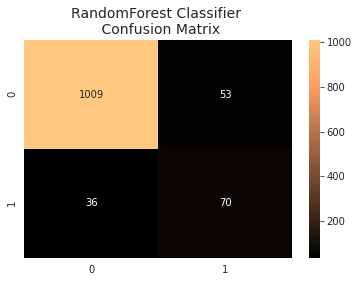

In [ ]:
rf_cf = confusion_matrix(y, y_class)
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper, fmt='d')
plt.title("RandomForest Classifier \n Confusion Matrix", fontsize=14);

We predict 70 failure out of 106.


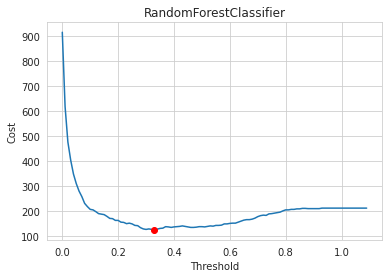

In [ ]:
cost_list = []
thrs = np.arange(0,1.1,.01)
fp_cost = 1    #1$
fn_cost = 2    #2$
for thr in thrs:
  preds = 1*(rf_pred[:,1]>thr)
  fp = np.sum((y.values == 0) & (preds == 1))
  fn = np.sum((y.values == 1) & (preds == 0))
  cost_list.append(fp*fp_cost + fn_cost*fn )
plt.plot(thrs, cost_list, '-')
best_thr = np.argmin(cost_list)
plt.plot(thrs[best_thr], cost_list[best_thr], 'ro')
plt.title('RandomForestClassifier');
plt.xlabel('Threshold')
plt.ylabel('Cost');
# false positive, device is not failed but labaled as failed ($1)
# false negative, device is failed but labaled as passed ($2)

If we assume that cost of replacing a working device(false positive, is half of price is half of price of a reparing a failed devie(false negative), then the cutoff point, would be around 0.3.


## Conclusion
1. Response is highly imbalanced.
2. Features are not representing the response a lot (they have very low correlation).
3. Because data is imbalanced, we use probablity + roc_auc score to find the best model, becasue roc is not dependent on threshold for classficaiton.
4. From all five machine learning techniques that I used (Logistic Regression,KNN, Decision Tree, Random Forest and Gradient Boosting), Gradient boosting and Random Forest had the best result. Then I used Oversampling(SMOTE) and Undersampling(NearMiss) techniques to make a balanced training set while using Random Forest and Oversampled trainig set and they didn't improve in AUC score.
5. For finding the optimal model, we used a search to find the optimal threshold to maximize F1-score. 
6. The cost associated with false positive and false negative is not known. Otherwise, we could have determine the threshold to minize the average cost.
7. With more data, we might be able to make better predictions, and could incorporate other techniques such as neural networks into the analysis. With more information on the cost of false negative/positives, we could also try updating a GBM model with a custom objective function to further optimize the training. In the real world, we might spend some research time digging into some of the attribute values to see if encoding specific values might also give lift to the model. 
